In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os,sys
import scipy.integrate as spi
from torch_geometric.data import Data
from sklearn.cluster import KMeans
CURRENT_DIR = os.getcwd()
module_path = os.path.abspath(os.path.join(CURRENT_DIR, "../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
from Anydim_transferability.DeepSet.model import DeepSet
from Anydim_transferability.O_n.model import ScalarModel, ScalarModel_KMeans
from Anydim_transferability.O_n import color_dict
from Anydim_transferability import typesetting
typesetting()

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess(model_name, X):
    if model_name == "SVD-Normalized DeepSet" or model_name == "SVD-DeepSet":
        S = torch.matmul(X.transpose(1, 2), X)  # num_pointclouds x 3 x 3
        U, _, _ = torch.svd(S)  # num_pointclouds x 3 x 3
        S = torch.matmul(X, U)  # num_pointclouds x num_points x 3
        return S
    elif model_name == "DS-CI (Normalized)":
        num_pointclouds = X.shape[0]
        n = X.shape[1]
        data = Data()
        Gram = torch.FloatTensor(torch.matmul(X, X.transpose(1, 2)))  # num_pointclouds x n x n
        off_mask = torch.triu(torch.ones(n, n)) == 1

        data.f_d = torch.diagonal(Gram, 0, dim1=1, dim2=2).unsqueeze(-1)  # num_pointclouds x n x 1
        data.f_o = Gram[:, off_mask].unsqueeze(-1)  # num_pointclouds x n(n-1)/2 x 1
        data.f_star = (
            (data.f_d * (torch.sum(Gram, dim=2, keepdim=True) - data.f_d)).sum(dim=1)
        ) / (
            n * (n - 1)
        )  # num_pointclouds x 1
        return data
    elif model_name == "OI-DS (Normalized)":
        num_pointclouds = X.shape[0]
        n = X.shape[1]
        K_all = np.zeros((num_pointclouds, 3, 3))
        data = Data()
        for i in range(num_pointclouds):
            kmeans = KMeans(n_clusters=3, random_state=0, init="k-means++", n_init=1).fit(X[i])
            K = kmeans.cluster_centers_  # (num_centroids, 3)
            # sort Kmeans centroid by norm
            indexlist = np.argsort(np.linalg.norm(K, axis=1))
            K = K[indexlist, :]
            K_all[i] = K
        K_all = torch.FloatTensor(K_all)
        data.f_o = torch.matmul(X, K_all.transpose(1, 2))  # num_pointclouds x n x k
        Gram_k = torch.matmul(K_all, K_all.transpose(1, 2))  # num_pointclouds x k x k
        data.f_d = Gram_k.reshape(num_pointclouds, 3 * 3)  # num_pointclouds x k^2
        return data

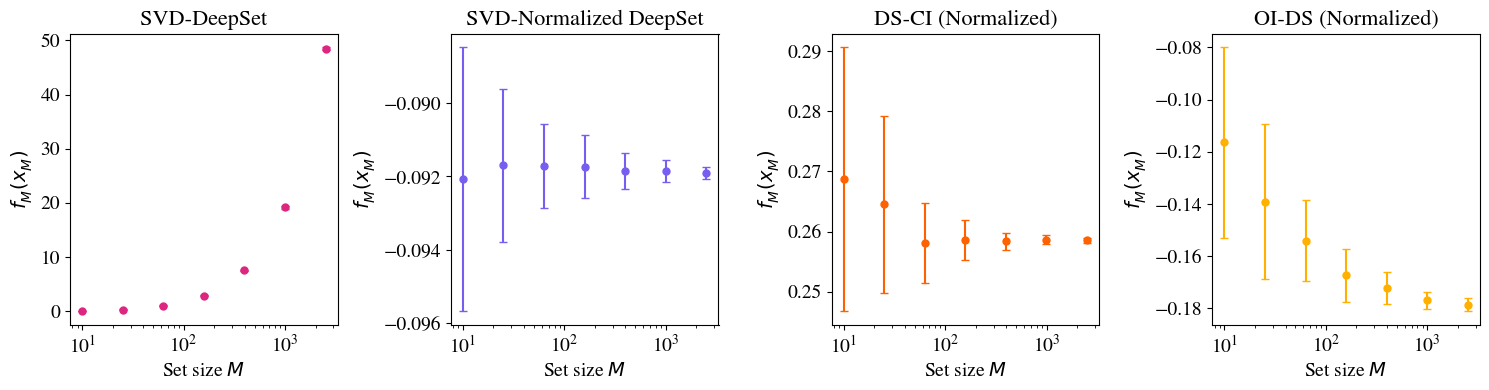

In [7]:
n_samples = 100
log_n_range = np.arange(1, 3.5, 0.4)

# fix input distribution
gaussian = torch.distributions.Normal(loc=0.0, scale=1.0)
torch.manual_seed(0)
# fix 4 models with random weights
params = {
    "hid_dim": 16,
    "out_dim": 1,
}
params["model_name"] = "SVD-DeepSet"
svdds = DeepSet(
    in_channels=3,
    out_channels=params["out_dim"],
    hidden_channels=params["hid_dim"],
    set_channels=params["hid_dim"] * 2,
    feature_extractor_num_layers=3,
    regressor_num_layers=2,
    normalization="sum",
)
svdds.eval()
params["model_name"] = "SVD-Normalized DeepSet"
svdds_normalized = DeepSet(
    in_channels=3,
    out_channels=params["out_dim"],
    hidden_channels=params["hid_dim"],
    set_channels=params["hid_dim"] * 2,
    feature_extractor_num_layers=3,
    regressor_num_layers=2,
    normalization="mean",
)
svdds_normalized.eval()
params["model_name"] = "DS-CI (Normalized)"
dsci = ScalarModel(**params)
dsci.eval()
params["model_name"] = "OI-DS (Normalized)"
oidsi = ScalarModel_KMeans(**params)
oidsi.eval()

# compute output
n_range = np.power(10, log_n_range).astype(int)
models = {
    "SVD-DeepSet": svdds,
    "SVD-Normalized DeepSet": svdds_normalized,
    "DS-CI (Normalized)": dsci,
    "OI-DS (Normalized)": oidsi,
}
outputs = {}
for model_name, model in models.items():
    outputs.setdefault(model_name, [])
    for i, n in enumerate(n_range):
        X = gaussian.sample((n_samples*3, n)).unsqueeze(-1)
        X = X.reshape(n_samples, 3, n).transpose(1, 2)

        X = preprocess(X=X, model_name=model_name)
        with torch.no_grad():
            output = model(X)
            outputs[model_name].append(output)

# plot
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

for ax, (model_name, color) in zip(axs, color_dict.items()):
    ax.errorbar(
        n_range,
        [float(outputs[model_name][i].mean(dim=0).squeeze()) for i in range(len(n_range))],
        [float(outputs[model_name][i].std(dim=0).squeeze()) for i in range(len(n_range))],
        fmt="o",
        capsize=3,
        markersize=5,
        color=color,
    )
    ax.set_xscale("log")
    ax.set_xlabel("Set size $M$", fontsize=14)
    ax.set_ylabel("$f_M(x_M)$", fontsize=14)
    ax.set_title(model_name, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=14)

plt.tight_layout()
plt.savefig(CURRENT_DIR + "/log/transferability/O(d)_transferability_outputs.png")
plt.savefig(CURRENT_DIR + "/log/transferability/O(d)_transferability_outputs.pdf")
plt.show()

/tmp/ipykernel_2675689/350090719.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(all_outputs.min(), all_outputs.max())


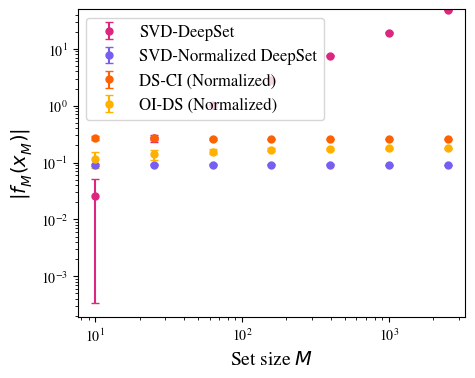

In [8]:
# plot
fig, ax = plt.subplots(figsize=(5, 4))

for model_name in models.keys():
    ax.errorbar(
        n_range,
        [abs(float(outputs[model_name][i].mean(dim=0).squeeze())) for i in range(len(n_range))],
        [abs(float(outputs[model_name][i].std(dim=0).squeeze())) for i in range(len(n_range))],
        fmt="o",
        capsize=3,
        markersize=5,
        color=color_dict[model_name],
        label=model_name,
    )
all_outputs = torch.stack([torch.stack(outputs[model]) for model in models.keys()])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Set size $M$", fontsize=14)
ax.set_ylabel("$|f_M(x_M)|$", fontsize=14)
ax.legend(fontsize=12, loc="upper left")
plt.ylim(all_outputs.min(), all_outputs.max())

plt.savefig(CURRENT_DIR + "/log/transferability/O(d)_transferability_outputs_combined.png")
plt.savefig(CURRENT_DIR + "/log/transferability/O(d)_transferability_outputs_combined.pdf")
plt.show()

In [26]:
all_outputs= torch.stack([torch.stack(outputs[model]) for model in models.keys()])

In [27]:
all_outputs.shape

torch.Size([3, 7, 100, 1])

In [25]:
len(all_outputs[0])

7